한영 번역기를 만든다.

### 목차
***
1. 데이터 다운로드
	1. 한글 데이터 가져오기
	2. 영어 데이터 가져오기
    
2. 데이터 정제
	1. 데이터쌍 만들기
	2. 중복데이터 제거
	3. 정규식 함수 정의 및 토큰화
	4. 한글, 영어 corpus 구축
3. 데이터 토큰화 _ tokenizer, tensor
4. 모델 설계
	1. Bahdanau Attention
	2. Encoder-Decoder
5. 훈련하기
	1. Optimizer & Loss
	2. train_step 구현
	3. 훈련시작
	4. 모델평가 및 시각화
6. 회고

### 필요 모듈 불러오기

In [1]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager.findfont(font)


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
import tensorflow as tf
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

## Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

- [깃허브를 데이터 저장소처럼 활용하기](https://computer-science-student.tistory.com/297)

In [4]:
#!wget https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
#!tar -xzvf korean-english-park.train.tar.gz

### (1) 한글 데이터 가져오기

In [5]:
path_to_zip_ko = tf.keras.utils.get_file('korean-english-park.train.tar.gz',
                                     origin = 'https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz',
                                     extract=True
                                     )

path_to_file_ko = os.path.dirname(path_to_zip_ko)+'/korean-english-park.train.ko'

8732672/8718893 [==============================] - 0s 0us/step


In [6]:
with open(path_to_file_ko, 'r') as f:
    ko_raw = f.read().splitlines()
    
print('Data Size:', len(ko_raw))
print('Example:')

for sen in ko_raw[0:100][::20]:
    print('>>', sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


### (2) 영어 데이터 가져오기

In [7]:
path_to_zip_en = tf.keras.utils.get_file('korean-english-park.train.tar.gz',
                                     origin = 'https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz',
                                     extract=True
                                     )

path_to_file_en = os.path.dirname(path_to_zip_en)+'/korean-english-park.train.en'

In [8]:
with open(path_to_file_en, 'r') as f:
    en_raw = f.read().splitlines()
    
print('Data Size:', len(en_raw))
print('Example:')

for sen in en_raw[0:100][::20]:
    print('>>', sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [134]:
ko_raw[:5]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
 '그러나 이것은 또한 책상도 필요로 하지 않는다.',
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
 '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.']

## Step 2. 데이터 정제
1. zip으로 데이터 쌍을 만든다.
2. 데이터 쌍의 중복 데이터 제거하고
3. 데이터마다의 중복 데이터가 있으면 쌍 제거
4. 제거한 데이터를 cleaned_corpus 저장
----------

5. 한글에 적용할 정규식 함수 재정의 + 토큰화
6. 영어에 <start\>토큰과 <end\> 토큰 추가 + 토큰화
7. eng_corpus, kor_corpus 각각 구축
    - 토큰 길이가 40 이하인 데이터 선별

### (1) zip으로 데이터 쌍 만들기

In [26]:
corpus = []
for pair in zip(ko_raw, en_raw):
    #pair = list(pair)
    corpus.append(pair)

In [137]:
#corpus

In [28]:
len(corpus)

94123

### (2) 데이터 쌍에서 중복 제거

In [44]:
corpus = set(corpus)

In [51]:
#corpus

In [46]:
len(corpus)

78968

### (3) 데이터마다의 중복데이터 있으면 제거_ 안함

In [47]:
only_ko = set(ko_raw)
len(only_ko)

77591

In [48]:
only_en = set(en_raw)
len(only_en)

75598

한글 데이터와 영어 데이터 각각 중복데이터가 약 1000개~3000개 갸량 더 있는데, 여기서 한글데이터의 중복을 제거하자니, 쌍으로 된 영어 데이터를 어떻게 선택할 지 문제고, 중복되는 영어는 제거해야 하는지도 의문이다. 

우선 데이터 정제 후 다시 쌍을 이뤄 중복을 제거해보자.

### (4) 중복제거 데이터 저장

In [49]:
cleaned_corpus = list(corpus)

In [138]:
cleaned_corpus[:3]

[('한 소녀가 기절하면 다른 소녀들이 뒤따르는', 'the teenagers check out just fine.'),
 ('그는 국가의 법이 제 구실을 못하고 일부 언론이 행정부와 흥정을 하지만 이제 비교적 언론의 자유가 존중되고 있다고 말했다.',
  "He noted that the courts don't work and some media outlets have made deals with the authorities. But there is now, he said, a relatively free press."),
 ('그러나 고릴라의 안전이 걱정된 몇 명의 경비대는 7일 다시 이 곳으로 돌아왔다.',
  'Concerned about the fate of the gorillas, a few rangers returned Friday.')]

### (5) 한글에 적용할 정규식 함수 재정의 + 토큰화

In [54]:
from konlpy.tag import Mecab
mecab = Mecab()

In [216]:
def preprocess_kor(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'([?,!.])', r' \1 ', sentence)
    sentence = re.sub(r'([" "]+)', " ", sentence)
    
    reg = re.compile('[^a-zㄱ-ㅎㅏ-ㅣ가-힣,?.! ]')
    sentence = reg.sub('', sentence)
    
    return mecab.morphs(sentence)

In [217]:
b = 'IMGD 는 내가 아무거나 쓴 것.'
b.lower()

'imgd 는 내가 아무거나 쓴 것.'

In [218]:
#preprocess_kor('그들의 생체 촉매 과정이 CO2를 기초적인 탄화수소인 C1(메탄, C2(에탄), C3(프로판)의 현태로 전환시켜 휘발유나 제트기 연료처럼 고품질 연료로 만드는데 활용할 수 있게 됐다.')

In [219]:
preprocess_kor('CNN 자매방송 CNN-IBN은 인도에서 몇 세기 동안 내려온 복잡한 사회 구습인 카스트 계급 질서가 인정되는 구자르 주민 일부가 4개 지역에서 발포하는 경찰과 충돌했다고 보도했다.')

['cnn',
 '자매',
 '방송',
 'cnnibn',
 '은',
 '인도',
 '에서',
 '몇',
 '세기',
 '동안',
 '내려온',
 '복잡',
 '한',
 '사회',
 '구습',
 '인',
 '카스트',
 '계급',
 '질서',
 '가',
 '인정',
 '되',
 '는',
 '구자르',
 '주민',
 '일부',
 '가',
 '개',
 '지역',
 '에서',
 '발포',
 '하',
 '는',
 '경찰',
 '과',
 '충돌',
 '했',
 '다고',
 '보도',
 '했',
 '다',
 '.']

### (6) 영어에 적용할 정규식 함수 + 토큰화

In [223]:
def preprocess_eng(sentence):
    sentence = sentence.lower()
    
    sentence = re.sub(r'([?,!.])', r' \1 ', sentence)
    sentence = re.sub(r'([" "]+)', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    
    sentence = '<start> ' + sentence
    sentence += ' <end>'
    
    return sentence.split()

In [224]:
#preprocess_eng('A German film fund said on Thursday it will grant subsidies worth 4.8 million euros ($6.5 million) for a controversial new film in which Tom Cruise plays a German hero executed for trying to kill Hitler.')

In [225]:
preprocess_eng("Members of the Gujjar community part of India's centuries-old, complex social caste order have engaged in clashes with police officers, who have opened fire in four districts, CNN's sister network, CNN-IBN reported.")

['<start>',
 'members',
 'of',
 'the',
 'gujjar',
 'community',
 'part',
 'of',
 'india',
 's',
 'centuries',
 'old',
 ',',
 'complex',
 'social',
 'caste',
 'order',
 'have',
 'engaged',
 'in',
 'clashes',
 'with',
 'police',
 'officers',
 ',',
 'who',
 'have',
 'opened',
 'fire',
 'in',
 'four',
 'districts',
 ',',
 'cnn',
 's',
 'sister',
 'network',
 ',',
 'cnn',
 'ibn',
 'reported',
 '.',
 '<end>']

### (7) kor_corpus, eng_corpus 구축
- cleaned_corpus 전처리하고
- 다시 zip 해서
- 토큰길이가 40 이하인 데이터만 kor_corpus, eng_corpus에 넣기

In [226]:
#preprocess_kor(cleaned_corpus[i][0])
#preprocess_eng(cleaned_corpus[i][1])

#### cleaned_corpus 전처리 후 임시파일에 각각 저장

In [227]:
kor_temp = [preprocess_kor(cleaned_corpus[i][0]) for i in range(len(cleaned_corpus))]
eng_temp = [preprocess_eng(cleaned_corpus[i][1]) for i in range(len(cleaned_corpus))]

In [228]:
kor_temp[:1]

[['한', '소녀', '가', '기절', '하', '면', '다른', '소녀', '들', '이', '뒤따르', '는']]

In [229]:
len(kor_temp)

78968

In [230]:
eng_temp
len(eng_temp)

78968

#### 임시파일 다시 zip 

In [231]:
corpus_temp = []
for pair in zip(kor_temp, eng_temp):
    corpus_temp.append(pair)

In [232]:
corpus_temp[:2]

[(['한', '소녀', '가', '기절', '하', '면', '다른', '소녀', '들', '이', '뒤따르', '는'],
  ['<start>',
   'the',
   'teenagers',
   'check',
   'out',
   'just',
   'fine',
   '.',
   '<end>']),
 (['그',
   '는',
   '국가',
   '의',
   '법',
   '이',
   '제',
   '구실',
   '을',
   '못',
   '하',
   '고',
   '일부',
   '언론',
   '이',
   '행정부',
   '와',
   '흥정',
   '을',
   '하',
   '지만',
   '이제',
   '비교',
   '적',
   '언론',
   '의',
   '자유',
   '가',
   '존중',
   '되',
   '고',
   '있',
   '다고',
   '말',
   '했',
   '다',
   '.'],
  ['<start>',
   'he',
   'noted',
   'that',
   'the',
   'courts',
   'don',
   't',
   'work',
   'and',
   'some',
   'media',
   'outlets',
   'have',
   'made',
   'deals',
   'with',
   'the',
   'authorities',
   '.',
   'but',
   'there',
   'is',
   'now',
   ',',
   'he',
   'said',
   ',',
   'a',
   'relatively',
   'free',
   'press',
   '.',
   '<end>'])]

#### 토큰길이 40 이하인 데이터만 담기

In [233]:
cleaned_corpus2 = [corpus_temp[i] for i in range(len(corpus_temp)) if (len(corpus_temp[i][1])<=40) and (len(corpus_temp[i][0])<=40)]

In [234]:
cleaned_corpus2[:2]

[(['한', '소녀', '가', '기절', '하', '면', '다른', '소녀', '들', '이', '뒤따르', '는'],
  ['<start>',
   'the',
   'teenagers',
   'check',
   'out',
   'just',
   'fine',
   '.',
   '<end>']),
 (['그',
   '는',
   '국가',
   '의',
   '법',
   '이',
   '제',
   '구실',
   '을',
   '못',
   '하',
   '고',
   '일부',
   '언론',
   '이',
   '행정부',
   '와',
   '흥정',
   '을',
   '하',
   '지만',
   '이제',
   '비교',
   '적',
   '언론',
   '의',
   '자유',
   '가',
   '존중',
   '되',
   '고',
   '있',
   '다고',
   '말',
   '했',
   '다',
   '.'],
  ['<start>',
   'he',
   'noted',
   'that',
   'the',
   'courts',
   'don',
   't',
   'work',
   'and',
   'some',
   'media',
   'outlets',
   'have',
   'made',
   'deals',
   'with',
   'the',
   'authorities',
   '.',
   'but',
   'there',
   'is',
   'now',
   ',',
   'he',
   'said',
   ',',
   'a',
   'relatively',
   'free',
   'press',
   '.',
   '<end>'])]

In [235]:
len(cleaned_corpus2)

62970

#### zip 해제 후 kor_corpus, eng_corpus 구축

In [236]:
# zip 해제
kor_corpus, eng_corpus = zip(*cleaned_corpus2)

In [237]:
# zip -> tuple 형태로 저장되므로 list로 다시 바꿔준다
kor_corpus = list(kor_corpus)
eng_corpus = list(eng_corpus)

In [238]:
print(kor_corpus[:1])
print(eng_corpus[:1])

[['한', '소녀', '가', '기절', '하', '면', '다른', '소녀', '들', '이', '뒤따르', '는']]
[['<start>', 'the', 'teenagers', 'check', 'out', 'just', 'fine', '.', '<end>']]


## Step 3. 데이터 토큰화
tokenize 함수를 정의하고, 이를 이용해 데이터를 텐서로 변환한다. 또한 각각의 tokenizer를 얻는다. 

단어의 수는 실험을 통해 적당한 값을 맞춰주도록 한다. (최소 10,000 이상)

난이도에 비해 데이터가 많지 않으므로 훈련 데이터와 검증 데이터를 따로 나누지 않는다.

In [248]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000,
                                                      filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')
    
    return tensor, tokenizer

In [249]:
# 토큰화 하기
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

print('Korean Vocab Size:', len(enc_tokenizer.index_word))
print('English Vocab Size:', len(dec_tokenizer.index_word))

Korean Vocab Size: 44413
English Vocab Size: 38454


In [250]:
enc_tokenizer.index_word

{1: '.',
 2: '다',
 3: '이',
 4: '는',
 5: '을',
 6: '의',
 7: '은',
 8: '에',
 9: '했',
 10: '를',
 11: '하',
 12: '가',
 13: '있',
 14: '들',
 15: '에서',
 16: '고',
 17: ',',
 18: '한',
 19: '다고',
 20: '으로',
 21: '것',
 22: '로',
 23: '그',
 24: '일',
 25: '과',
 26: '인',
 27: '명',
 28: '와',
 29: '지',
 30: '말',
 31: '었',
 32: '적',
 33: '기',
 34: '라고',
 35: '년',
 36: '할',
 37: '도',
 38: '되',
 39: '밝혔',
 40: '수',
 41: '않',
 42: '된',
 43: '미국',
 44: '게',
 45: '대통령',
 46: '만',
 47: '됐',
 48: '습니다',
 49: '해',
 50: '시간',
 51: '았',
 52: '에게',
 53: '어',
 54: '전',
 55: '던',
 56: '중',
 57: '받',
 58: '월',
 59: '며',
 60: '이번',
 61: '정부',
 62: '대한',
 63: '전했',
 64: '위해',
 65: '현지',
 66: '지난',
 67: '없',
 68: '주',
 69: '경찰',
 70: '까지',
 71: '이라크',
 72: '지만',
 73: '대해',
 74: '지역',
 75: '사람',
 76: '될',
 77: '그러나',
 78: '면',
 79: '중국',
 80: '발생',
 81: '자',
 82: '한다',
 83: '미',
 84: '아',
 85: '달러',
 86: '자신',
 87: '북한',
 88: '한편',
 89: '주장',
 90: '사망',
 91: '다는',
 92: '예정',
 93: '다른',
 94: '같',
 95: '나',
 96: '으며',
 97: '더

In [251]:
print(len(enc_tensor))
print(len(dec_tensor))

62970
62970


## Step 4. 모델 설계
한국어를 영어로 번역할 Attention 기반 Seq2seq 모델을 설계한다.  
모델에 Dropout 모듈을 추가하면 성능이 더 좋아진다.  
Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰준다.

#### Bahdanau Attention

In [252]:
# Bahdanau Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
        
    def call(self, h_enc, h_dec):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]
        
        # 1. units 차원으로 만든다
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        # 2. h_enc, h_dec feedforward???
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # 3. softmax 적용
        attn = tf.nn.softmax(score, axis=1)
        
        # 4. h_enc x softmax
        context_vec = attn * h_enc
        
        # 5. 적용된 곱셈값(context_vec) 모두 더하기
        context_vec = tf.reduce_sum(context_vec, axis=1)
        
        return context_vec, attn

#### Encoder - Decoder

In [253]:
# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, 
                                      return_sequences=True)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [254]:
# Decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                      return_sequences=True,
                                      return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)
        
        return out, h_dec, attn

## Step 5. 훈련하기
### (1) Optimizer와 Loss

In [255]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # mask는 padding 문제 방지 위한 역할
    # 0: <PAD>에 해당하는 인덱스가 들어가는 자리
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### (2) train_step 구현
필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수

In [256]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)
        # 문장 개수를 추가해준건가
        
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
            
    batch_loss = (loss / int(tgt.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### (3) 훈련 시작하기

In [257]:
BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)


In [258]:
from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                               dec_tensor[idx:idx+BATCH_SIZE],
                               encoder,
                               decoder,
                               optimizer,
                               dec_tokenizer)
        
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 10: 100%|██████████| 984/984 [10:36<00:00,  1.55it/s, Loss 1.3656]


### (4) 모델 평가 및 시각화

In [259]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_kor(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, 
                                                          maxlen=enc_tensor.shape[-1],
                                                          padding='post')
    
    result = ''
    
    enc_out = encoder(inputs)
    
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)
    
    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, 
                                                            dec_hidden,
                                                            enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        
        result += dec_tokenizer.index_word[predicted_id] + ' '
        
        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize':14}
    
    ax.set_xticklabels(['']+sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(['']+predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
    
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))
    

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the strongest candidate . <end> 


/tmp/ipykernel_31/66593064.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/66593064.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+predicted_sentence, fontdict=fontdict)


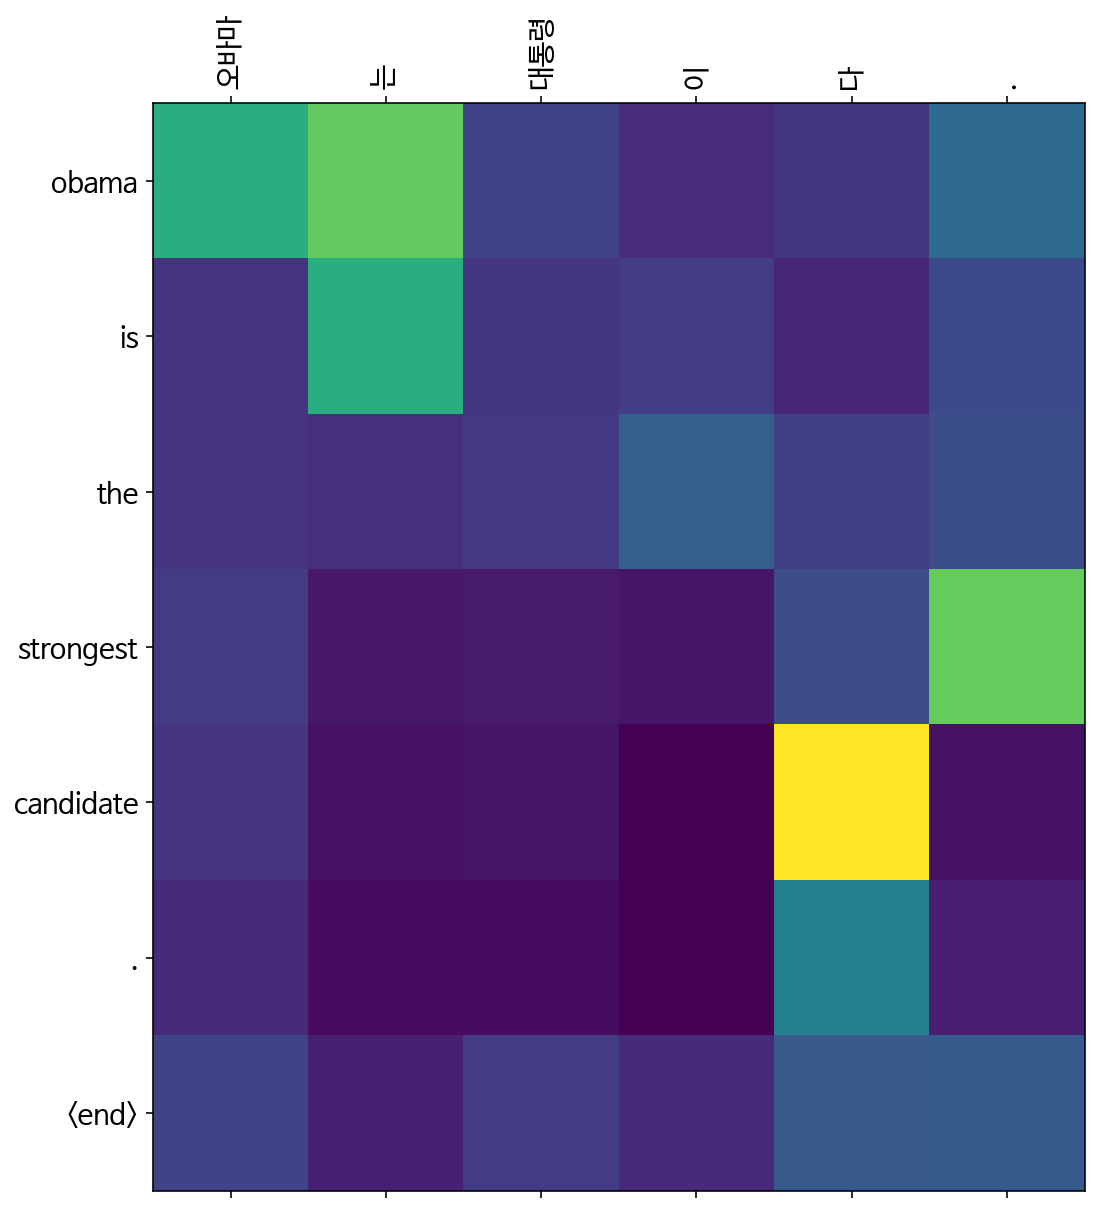

In [260]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the protesters are in the city of the city . <end> 


/tmp/ipykernel_31/66593064.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/66593064.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+predicted_sentence, fontdict=fontdict)


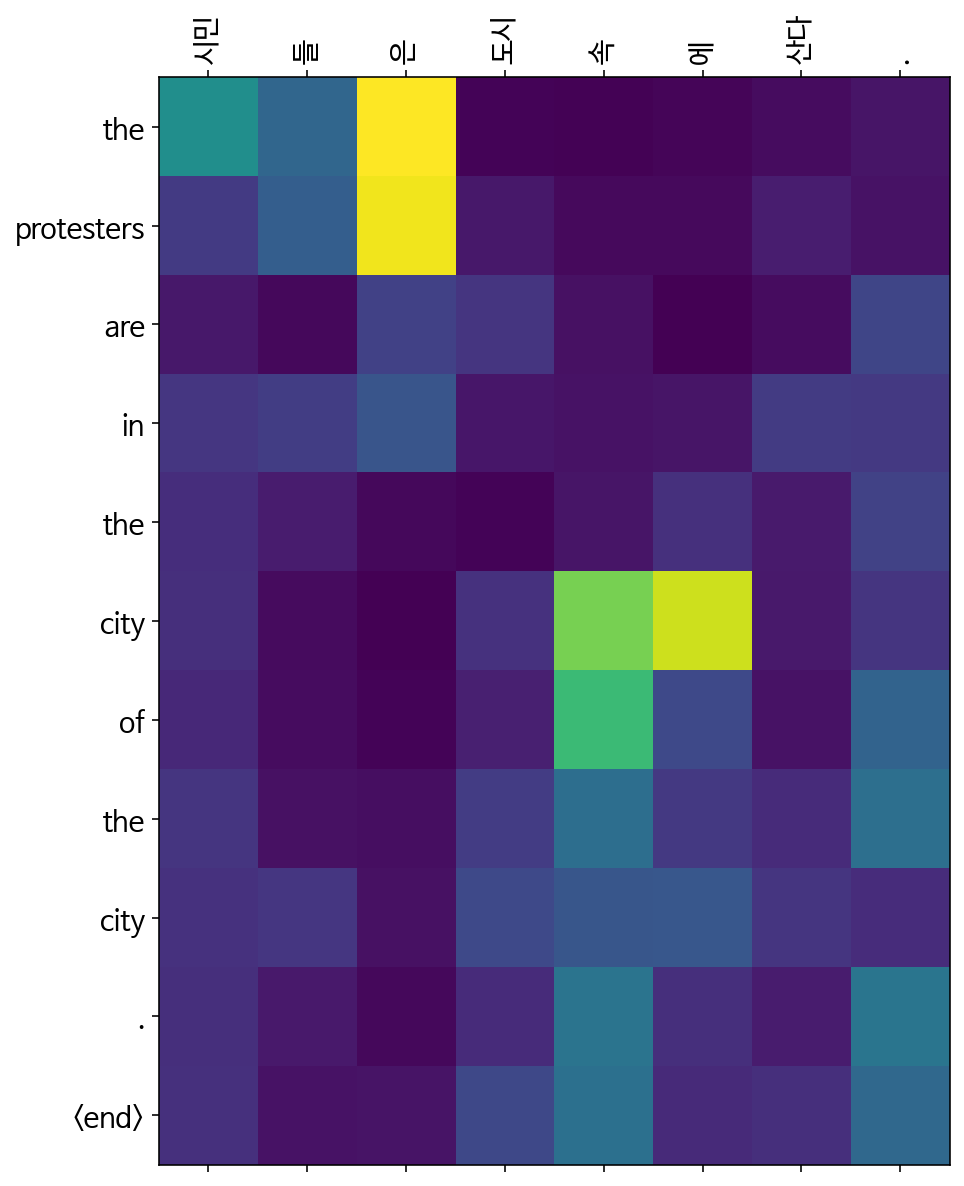

In [261]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: caffeine is still not so . <end> 


/tmp/ipykernel_31/66593064.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/66593064.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+predicted_sentence, fontdict=fontdict)


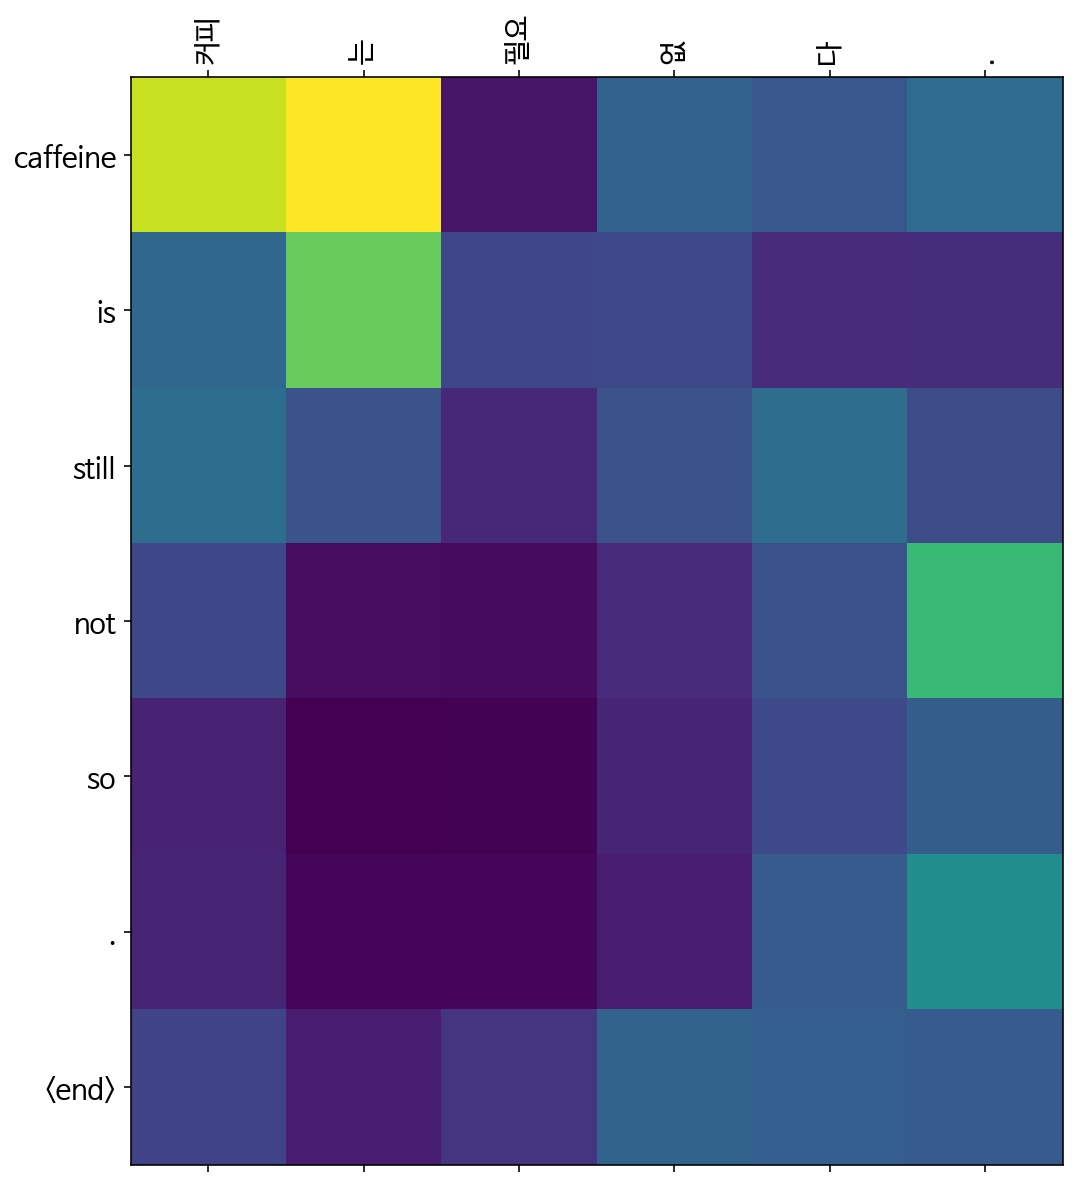

In [262]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven people were killed . <end> 


/tmp/ipykernel_31/66593064.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/66593064.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+predicted_sentence, fontdict=fontdict)


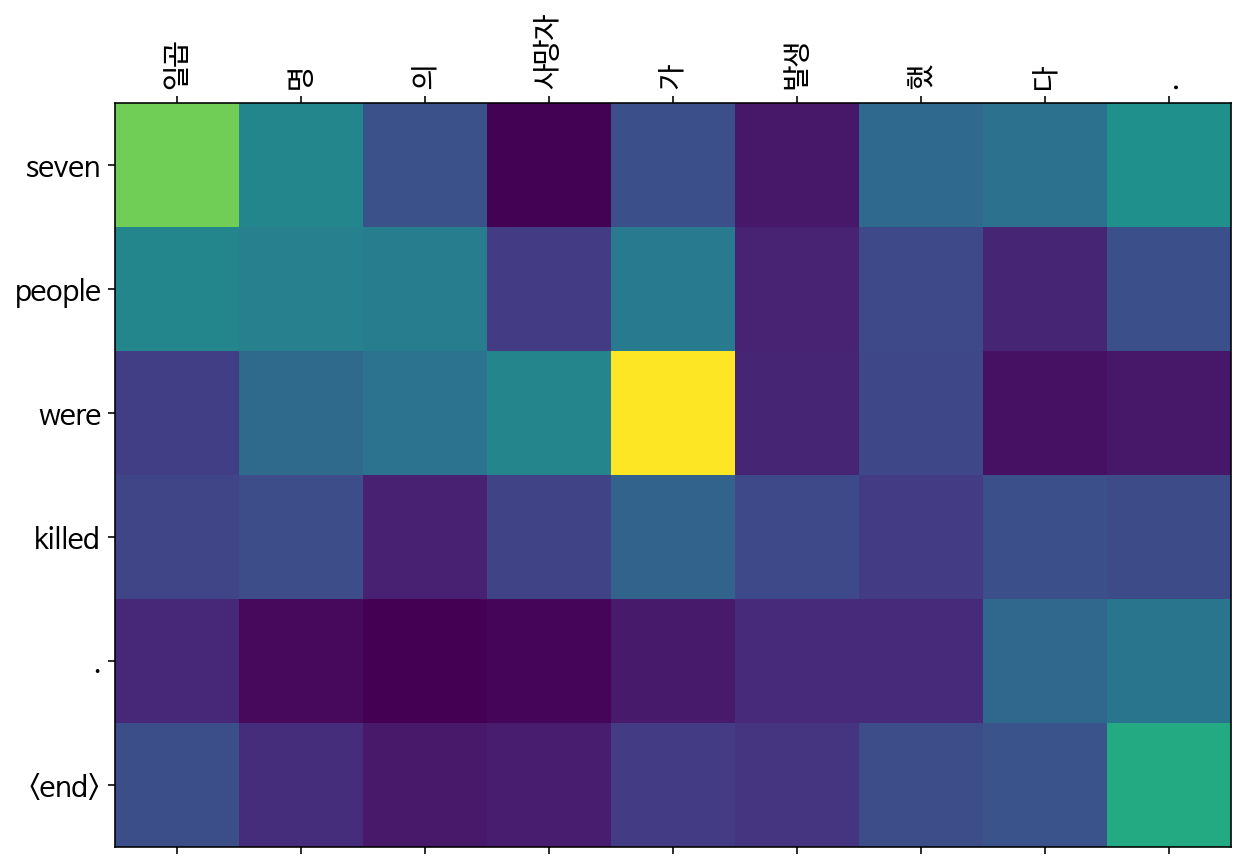

In [263]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

***
### 회고
노드에서는 영어-스페인어라서 전처리를 할 때에도 split()으로 한번에 처리할 수 있었는데, 한국어-영어는 아무래도 토큰화 방식이 다르다 보니 함수를 다르게 정의해줘야했다.  

또 영어-스페인어는 데이터가 쌍으로 묶여있었는데, 이번 한국어-영어 데이터는 데이터셋이 순서만 같게 따로 뭉쳐있어서 이 순서를 망치지 않고 전처리를 해야했다. 그래서 zip으로 데이터 쌍을 만들어주고, 중복을 처리하는 등의 전처리 작업을 했는데, 그러다보니 중복되는 한국어에 다른 영어 해석이 붙는 등의 문제가 있었다. 이걸 해결하면 정확도가 올라갔을까 싶지만 일단 그대로 두었다.

한국어를 어떻게 처리할까 싶어 데이터를 보는데, 영어나 숫자가 섞여있는 데이터가 많았다. 이 경우 영어는 대부분 개체를 나타내거나 고유명사의 이름이었다. 이걸 지우면 한국어를 영어로 번역할 때 혼선이 있을까봐 전처리 과정에서 대문자 영어 A-Z와 숫자 0-9를 포함시켰다.  
영어데이터를 전처리 할 때에도 숫자를 포함시켰다.  

이렇게 데이터를 학습시켜보니 Loss가 2 정도에 머물러 있었다.   
번역 성능도 좋지 못했다. '오바마는 대통령이다.'를 'obama is necessary.' 라고 번역하던가, '커피는 필요없다.'에서는 알 수 없는 같은 말이 반복되어 번역되는 등 성능이 정말 안 좋았다. 

이건 모델 학습보다도 전처리가 부족한 듯하여 전처리 함수를 수정하였다. 앞서 한국어 데이터를 처리할 때 A-Z와 0-9를 포함시켰는데, 생각해보니 영어 데이터를 처리할 때 lower()함수를 이용해서 소문자로 다 바꿔주었으니, 한국어 데이터에 있는 영어에도 이게 적용되어야 할 것 같았다. 그래서 lower()과정을 추가하고 A-Z를 a-z로 바꿔주었으며 숫자0-9는 포함시키지 않기로 했다.   tokenizer의 word_index를 확인해보니 단어사전에 숫자가 포함되어 있었고 이것 때문에 포함되어야 할 단어가 포함되지 않아 성능을 저하시키는 건가 싶었기 때문이다.   
영어 데이터도 마찬가지로 숫자 데이터는 제거했다.  
또 토큰화하는 과정에서 num_words = 10000으로 제한해주었다.(원래는 모든 단어 사용)

결과적으로 성능이 확연히 좋아졌다. Loss 값도 1 정도로 전에 비해 많이 떨어졌다. 또 위에서 확인할 수 있듯이 '오바마는 대통령이다.' 문장을 'obama is the strongest candidate.' 로 번역하고, '일곱 명의 사망자가 발생했다.'를  'seven people were killed.'라고 하는 등 거의 비슷한 내용으로 번역하는 것을 볼 수 있다 (이전의 모델에서 '일곱 명의 사망자~' 문장을 번역할 때, seven이라는 단어는 나오지도 않았다). 

아직 문법도 어색하고 정확하게 번역되지 않아 갈 길이 멀지만 전처리와 파라미터의 수정으로 성능이 이렇게 달라질 수 있음을 배웠다. 